In [125]:
import pandas as pd
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Qasim2004",
    database="stock_news"
)

# Loading only rows that are fully ready for modeling
query = """
SELECT
    sentiment_score,
    confidence_score,
    price_change_pct_1h,
    price_change_pct_4h,
    price_change_pct_24h,
    matched_keywords,
    price_label_4d
FROM headlines
WHERE price_label_4d IS NOT NULL
  AND sentiment_score IS NOT NULL
  AND sentiment_score != 0  -- Exclude neutral rows
  AND confidence_score IS NOT NULL
  AND price_change_pct_1h IS NOT NULL
  AND price_change_pct_4h IS NOT NULL
  AND price_change_pct_24h IS NOT NULL
"""

df = pd.read_sql(query, conn)
conn.close()

df.head()


/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_72488/2012620461.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,sentiment_score,confidence_score,price_change_pct_1h,price_change_pct_4h,price_change_pct_24h,matched_keywords,price_label_4d
0,-0.133,0.4,-0.02,0.14,-1.04,"investment, slowing, slow",Down
1,0.500,0.5,0.07,0.22,1.62,debuts,Neutral
2,0.900,0.9,-1.02,0.70,1.33,celebrates,Neutral
3,0.300,0.3,-0.05,0.26,1.41,partners with,Neutral
4,0.400,0.4,0.00,0.58,0.77,acquisition,Neutral


In [126]:
# Creating a new column that counts how many keywords were matched in the headline
df['keyword_count'] = df['matched_keywords'].apply(
    lambda x: 0 if x == 'none' or pd.isnull(x) else len(x.split(', '))
)

# preview the result
df[['matched_keywords', 'keyword_count']].head()


,matched_keywords,keyword_count
0,"investment, slowing, slow",3
1,debuts,1
2,celebrates,1
3,partners with,1
4,acquisition,1


In [127]:
# Choose features (X) and the target (y)
features = [
    "sentiment_score",
    "confidence_score",
    "price_change_pct_1h",
    "price_change_pct_4h",
    "price_change_pct_24h",
    "keyword_count"
]

target = "price_label_4d"

X = df[features]
y = df[target]

# Confirm shapes
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (437, 6)
y shape: (437,)


In [128]:
#4. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# evaluate
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[34 12  7]
 [13 14  5]
 [ 1  9 15]]
              precision    recall  f1-score   support

        Down       0.71      0.64      0.67        53
     Neutral       0.40      0.44      0.42        32
          Up       0.56      0.60      0.58        25

    accuracy                           0.57       110
   macro avg       0.55      0.56      0.56       110
weighted avg       0.58      0.57      0.58       110



In [129]:
# Showing sample inputs and predictions
sample = X_test.iloc[:5]
actual = y_test.iloc[:5]
predicted = clf.predict(sample)

# Display results 
for i in range(len(sample)):
    print(f"Headline {i+1}")
    print(f"→ Features: {sample.iloc[i].to_dict()}")
    print(f"→ Actual label: {actual.iloc[i]}")
    print(f"→ Predicted label: {predicted[i]}")
    print("-" * 40)


Headline 1
→ Features: {'sentiment_score': 0.4, 'confidence_score': 0.4, 'price_change_pct_1h': 0.36, 'price_change_pct_4h': -0.2, 'price_change_pct_24h': 0.1, 'keyword_count': 1.0}
→ Actual label: Down
→ Predicted label: Up
----------------------------------------
Headline 2
→ Features: {'sentiment_score': 0.6, 'confidence_score': 0.6, 'price_change_pct_1h': -0.45, 'price_change_pct_4h': -0.09, 'price_change_pct_24h': 3.77, 'keyword_count': 2.0}
→ Actual label: Up
→ Predicted label: Up
----------------------------------------
Headline 3
→ Features: {'sentiment_score': 0.95, 'confidence_score': 0.95, 'price_change_pct_1h': -0.29, 'price_change_pct_4h': -0.78, 'price_change_pct_24h': -0.97, 'keyword_count': 1.0}
→ Actual label: Neutral
→ Predicted label: Neutral
----------------------------------------
Headline 4
→ Features: {'sentiment_score': 0.3, 'confidence_score': 0.3, 'price_change_pct_1h': 0.0, 'price_change_pct_4h': -0.65, 'price_change_pct_24h': -0.65, 'keyword_count': 1.0}
→ A

In [130]:
#mini prediction script (fake data example)
# Load model and features


def predict_label(input_features: dict):
    """
    Predict stock movement using the trained classifier.

    input_features = {
        'sentiment_score': ...,
        'confidence_score': ...,
        'price_change_pct_1h': ...,
        'price_change_pct_4h': ...,
        'price_change_pct_24h': ...,
        'keyword_count': ...
    }
    """
    df = pd.DataFrame([input_features])[features]
    prediction = clf.predict(df)[0]  # Use the trained classifier directly
    return prediction

# Example test
test_input = {
    'sentiment_score': 0.6,
    'confidence_score': 0.8,
    'price_change_pct_1h': 0.3,
    'price_change_pct_4h': 0.5,
    'price_change_pct_24h': 0.4,
    'keyword_count': 2
}
print("Predicted label:", predict_label(test_input))



Predicted label: Up


In [131]:
# Pulling rows from my dataframe

sample_rows = df.sample(3, random_state=42)  

for i, row in enumerate(sample_rows.itertuples(), start=1):
    input_dict = {
        'sentiment_score': row.sentiment_score,
        'confidence_score': row.confidence_score,
        'price_change_pct_1h': row.price_change_pct_1h,
        'price_change_pct_4h': row.price_change_pct_4h,
        'price_change_pct_24h': row.price_change_pct_24h,
        'keyword_count': row.keyword_count
    }
    actual = row.price_label_4d
    predicted = predict_label(input_dict)
    
    print(f"\nHeadline {i}")
    print("→ Features:", input_dict)
    print("→ Actual label:", actual)
    print("→ Predicted label:", predicted)



Headline 1
→ Features: {'sentiment_score': 0.4, 'confidence_score': 0.4, 'price_change_pct_1h': 0.36, 'price_change_pct_4h': -0.2, 'price_change_pct_24h': 0.1, 'keyword_count': 1}
→ Actual label: Down
→ Predicted label: Up

Headline 2
→ Features: {'sentiment_score': 0.6, 'confidence_score': 0.6, 'price_change_pct_1h': -0.45, 'price_change_pct_4h': -0.09, 'price_change_pct_24h': 3.77, 'keyword_count': 2}
→ Actual label: Up
→ Predicted label: Up

Headline 3
→ Features: {'sentiment_score': 0.95, 'confidence_score': 0.95, 'price_change_pct_1h': -0.29, 'price_change_pct_4h': -0.78, 'price_change_pct_24h': -0.97, 'keyword_count': 1}
→ Actual label: Neutral
→ Predicted label: Neutral


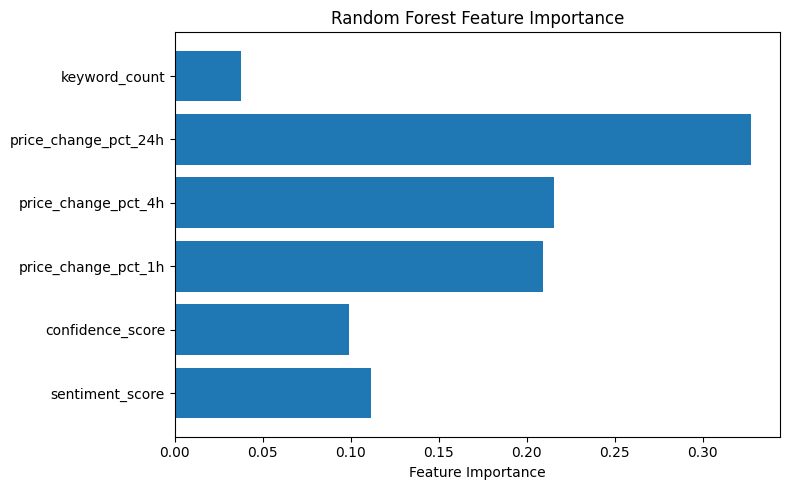

In [132]:
#feature importance plot
import matplotlib.pyplot as plt


importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


In [133]:
# Pull real rows from headlines table
import mysql.connector
import pandas as pd

# Assumes 'clf' is already trained earlier in the notebook
# Assumes 'features' list is already defined

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Qasim2004",
    database="stock_news"
)

query = """
    SELECT
        id,
        headline,
        sentiment_score,
        confidence_score,
        price_change_pct_1h,
        price_change_pct_4h,
        price_change_pct_24h,
        matched_keywords,
        price_label_4d
    FROM headlines
    WHERE 
        price_label_4d IS NOT NULL
        AND sentiment_score IS NOT NULL
        AND sentiment_score != 0            -- excludes neutral ones
        AND confidence_score IS NOT NULL
        AND price_change_pct_1h IS NOT NULL
        AND price_change_pct_4h IS NOT NULL
        AND price_change_pct_24h IS NOT NULL
    ORDER BY id DESC
    LIMIT 5
"""

df_real = pd.read_sql(query, conn)
conn.close()

# Compute keyword count
df_real['keyword_count'] = df_real['matched_keywords'].apply(
    lambda x: 0 if x == 'none' or pd.isnull(x) else len(x.split(', '))
)


# Extract features and labels
X_live = df_real[features]
y_live = df_real['price_label_4d']

# Make predictions using the trained classifier
predicted = clf.predict(X_live)

# Display results
for i in range(len(X_live)):
    print(f"Headline {i+1}")
    print(f"→ Headline text: {df_real['headline'].iloc[i]}")
    print(f"→ Features: {X_live.iloc[i].to_dict()}")
    print(f"→ Actual label: {'Up' if y_live.iloc[i]==1 else 'Down'}")
    print(f"→ Predicted label: {'Up' if predicted[i]==1 else 'Down'}")
    print("-" * 40)


Headline 1
→ Headline text: IonQ, Inc. (IONQ) Stock Sinks As Market Gains: What You Should Know
→ Features: {'sentiment_score': 0.6, 'confidence_score': 0.6, 'price_change_pct_1h': 1.51, 'price_change_pct_4h': 1.51, 'price_change_pct_24h': 1.51, 'keyword_count': 1.0}
→ Actual label: Down
→ Predicted label: Down
----------------------------------------
Headline 2
→ Headline text: Ecopetrol (EC) Stock Drops Despite Market Gains: Important Facts to Note
→ Features: {'sentiment_score': -0.1, 'confidence_score': 0.7, 'price_change_pct_1h': 0.22, 'price_change_pct_4h': 0.22, 'price_change_pct_24h': 0.22, 'keyword_count': 2.0}
→ Actual label: Down
→ Predicted label: Down
----------------------------------------
Headline 3
→ Headline text: Enphase Energy (ENPH) Stock Dips While Market Gains: Key Facts
→ Features: {'sentiment_score': 0.6, 'confidence_score': 0.6, 'price_change_pct_1h': 0.64, 'price_change_pct_4h': 0.64, 'price_change_pct_24h': 0.64, 'keyword_count': 1.0}
→ Actual label: Down
→ 

/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_72488/432284894.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_real = pd.read_sql(query, conn)


In [97]:
print(df['price_label_4d'].value_counts(normalize=True))


price_label_4d
Down       0.396576
Neutral    0.316690
Up         0.286733
Name: proportion, dtype: float64


RANDOM FOREST REGRESSOR

In [ ]:
# Regression dataframe — safely includes the 4d price change
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Qasim2004",
    database="stock_news"
)

regression_query = """
SELECT
    sentiment_score,
    confidence_score,
    matched_keywords,
    price_change_pct_24h
FROM headlines
WHERE sentiment_score IS NOT NULL
  AND confidence_score IS NOT NULL
  AND price_change_pct_24h IS NOT NULL
  AND matched_keywords IS NOT NULL
"""

df_regression = pd.read_sql(regression_query, conn)

# Compute keyword_count from matched_keywords
df_regression["keyword_count"] = df_regression["matched_keywords"].apply(
    lambda x: len(x.split(",")) if pd.notnull(x) else 0
)

# Optionally drop matched_keywords now
df_regression = df_regression.drop(columns=["matched_keywords"])

print("Regression DataFrame shape:", df_regression.shape)
df_regression.head()


Regression DataFrame shape: (3870, 4)


/var/folders/8n/rfbb5wx545s1sgtlncggpk240000gn/T/ipykernel_72488/1309259877.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_regression = pd.read_sql(regression_query, conn)


,sentiment_score,confidence_score,price_change_pct_24h,keyword_count
0,-0.133,0.4,-1.04,3
1,0.500,0.5,1.62,1
2,0.900,0.9,1.33,1
3,0.300,0.3,1.41,1
4,0.000,0.0,-0.25,1


In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [66]:
X_reg = df_regression[["sentiment_score", "confidence_score", "keyword_count"]]
y_reg = df_regression["price_change_pct_24h"]

In [67]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


In [68]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_reg, y_train_reg)


RandomForestRegressor(random_state=42)

In [69]:
y_pred_reg = regressor.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("Mean Squared Error (4d):", round(mse, 4))
print("R² Score (4d):", round(r2, 4))


Mean Squared Error (4d): 11.0741
R² Score (4d): -0.0279


In [71]:
results_df = pd.DataFrame({
    "Actual 24h %": y_test_reg.values,
    "Predicted 24h %": y_pred_reg
})
results_df.head(10)


,Actual 24h %,Predicted 24h %
0,1.10,0.439456
1,-0.81,0.439456
2,-0.31,0.439456
3,-0.83,-0.122296
4,1.32,0.439456
5,1.01,0.482771
6,-10.57,-0.090400
7,1.97,0.439456
8,-0.97,0.075605
9,11.76,0.535753


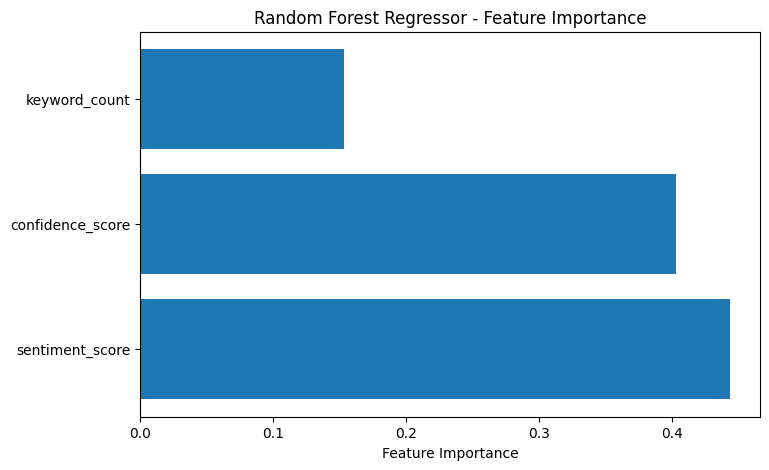

In [72]:
# Feature importance
import matplotlib.pyplot as plt

feature_names = X_train_reg.columns
importances = regressor.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Regressor - Feature Importance")
plt.show()
